# Amazon Sentiment Analysis



Import data from Kaggle

In [330]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'amazon-fine-food-reviews' dataset.
Path to dataset files: /kaggle/input/amazon-fine-food-reviews


In [331]:
# =========================
# CORE / DATA HANDLING
# =========================
import os
import csv
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS  # for token frequency

# =========================
# VISUALISATION
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# =========================
# COLAB / DATA I/O
# =========================
from google.colab import drive, files

In [332]:
csv_path = os.path.join(path, "Reviews.csv")
print("Loading:", csv_path)

df = pd.read_csv(csv_path)
df.head(2)

Loading: /kaggle/input/amazon-fine-food-reviews/Reviews.csv


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


---
---
## Derived Metrics for Data Understanding
---
---



Converted Unix Time to datetime review_time for readability, then dropped the original Time column

In [333]:
df["review_time"] = pd.to_datetime(df["Time"], unit="s", errors="coerce")
df = df.drop(columns=["Time"])

Adding two columns:
* text_len - the n of characters per review.
* word_count - the n of words per review

In [334]:
df["text_len"] = df["Text"].astype(str).str.len()
df["word_count"] = df["Text"].astype(str).str.split().str.len()

In [335]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,review_time,text_len,word_count
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,263,48
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,190,31


I’m using only 1★ and 5★ reviews because they provide a clear, low-noise sentiment signal. The extremes are linguistically distinct (“terrible” vs "great”), while 2–4★ often mix factors like delivery/price and add ambiguity.
<br/> <br/>This choice improves separability and gives a strong baseline before tackling the noisier mid-range.

In [336]:
score_to_binary = {1: "negative", 5: "positive"}
df["sentiment"] = df["Score"].map(score_to_binary)

In [337]:
df_bin = df[df["Score"].isin([1, 5])].copy()
df_bin["sentiment"] = df_bin["Score"].map(score_to_binary)

# tidy index
df_bin.reset_index(drop=True, inplace=True)

df = df_bin

In [338]:
print(df["sentiment"].value_counts())
print((df["sentiment"].value_counts(normalize=True)*100).round(2))

sentiment
positive    363122
negative     52268
Name: count, dtype: int64
sentiment
positive    87.42
negative    12.58
Name: proportion, dtype: float64


---
---
## Data Understanding
---
---



Code base structure and integrity

In [339]:
# shape
print("Shape:", df.shape)
print("----------------------------------------------------------------------\n\n")

# info
df.info()
print("----------------------------------------------------------------------\n\n")

# missing values
na_counts = df.isna().sum().sort_values(ascending=False)
print(na_counts)
print("----------------------------------------------------------------------\n\n")


# duplicates
dup_text = df.duplicated(subset=["Text"]).sum()
print("Duplicate Text rows:", dup_text)


Shape: (415390, 13)
----------------------------------------------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415390 entries, 0 to 415389
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      415390 non-null  int64         
 1   ProductId               415390 non-null  object        
 2   UserId                  415390 non-null  object        
 3   ProfileName             415366 non-null  object        
 4   HelpfulnessNumerator    415390 non-null  int64         
 5   HelpfulnessDenominator  415390 non-null  int64         
 6   Score                   415390 non-null  int64         
 7   Summary                 415390 non-null  object        
 8   Text                    415390 non-null  object        
 9   review_time             415390 non-null  datetime64[ns]
 10  text_len                415390 non-null  int64         
 11

Quantity of reviews per score

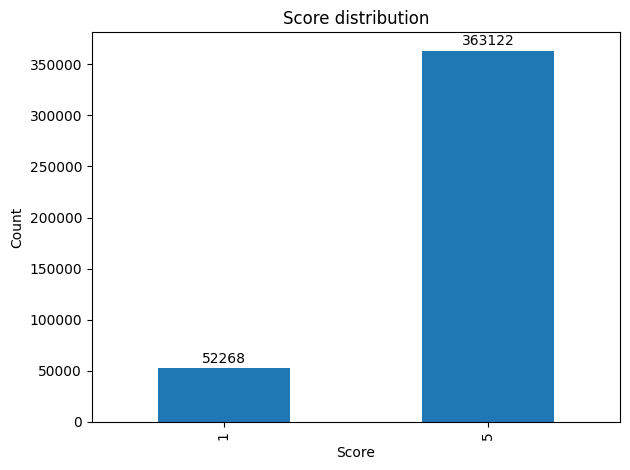

In [340]:
# scores viz
score_counts = df["Score"].value_counts().sort_index()
ax = score_counts.plot(kind="bar")
ax.set_title("Score distribution"); ax.set_xlabel("Score"); ax.set_ylabel("Count")
ax.bar_label(ax.containers[0], padding=2)
plt.tight_layout(); plt.show()

In [341]:
# score percentage
(score_counts / score_counts.sum() * 100).round(2)


,count
Score,
1,12.58
5,87.42


Quantity of reviews per word count

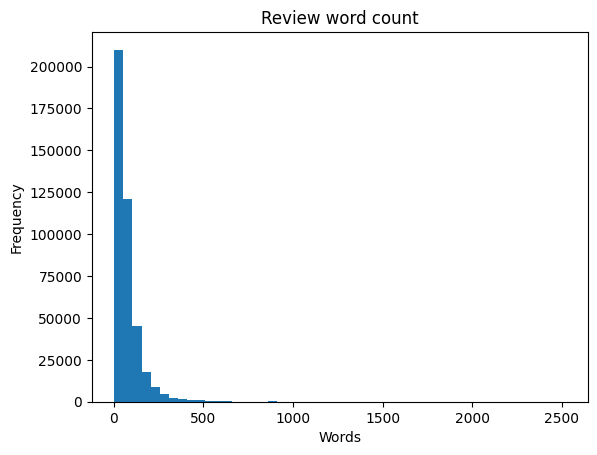

In [342]:
# word count distribution
df["word_count"].plot(kind="hist", bins=50)
plt.title("Review word count")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

Quantity of reviews per time

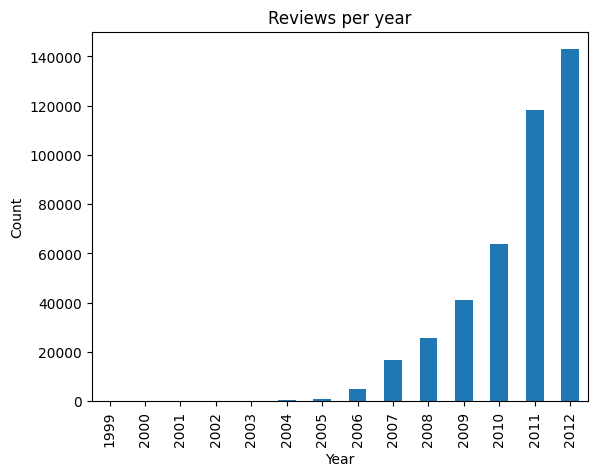

In [343]:
# review length over time
df.groupby(df["review_time"].dt.year)["Id"].count().plot(kind="bar")
plt.title("Reviews per year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

Unigrams and bigrams

In [344]:
# pick only scores 1 and 5
d1 = df[df["Score"] == 1]["Text"].astype(str)
d5 = df[df["Score"] == 5]["Text"].astype(str)

# sample to same size so frequencies are comparable
n = min(len(d1), len(d5), 50000)  # cap for speed
d1s = d1.sample(n, random_state=42)
d5s = d5.sample(n, random_state=42)


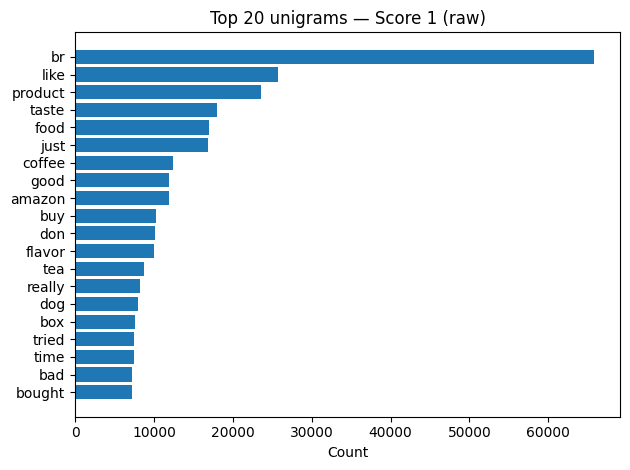

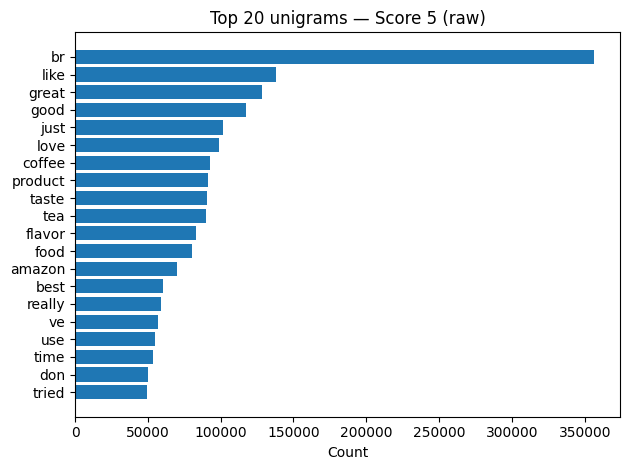

In [345]:
# Unigrams (raw)
for s in [1, 5]:
    top_terms_raw_score(df, s, ngram=(1,1), topn=20, min_df=3, max_features=20000)

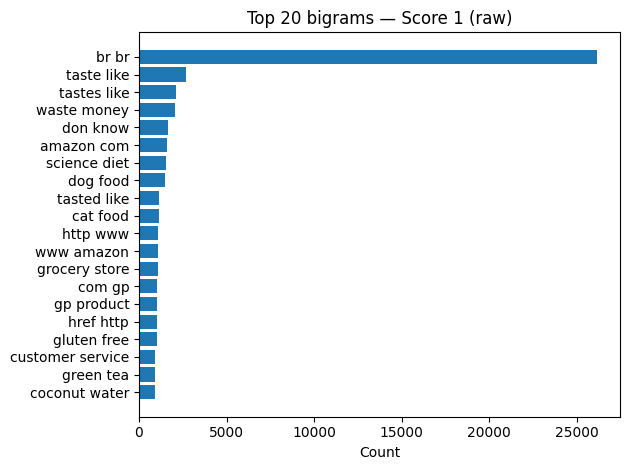

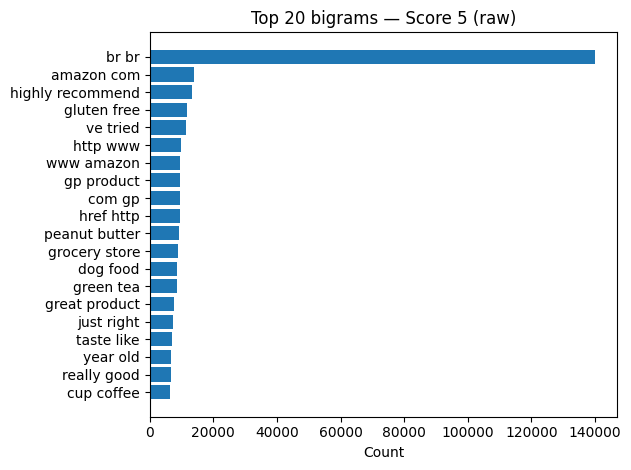

In [346]:
# Bigrams (raw)
for s in [1, 5]:
    top_terms_raw_score(df, s, ngram=(2,2), topn=20, min_df=3, max_features=40000)

Word cloud

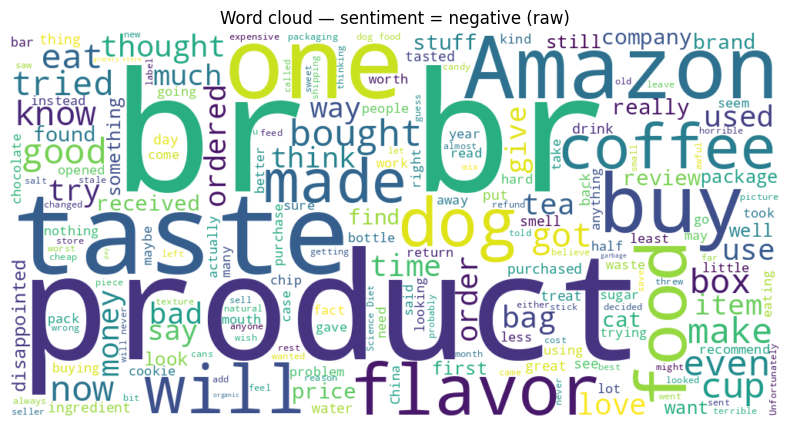

In [347]:
wordcloud_for_value(df, "negative", use_clean=False)

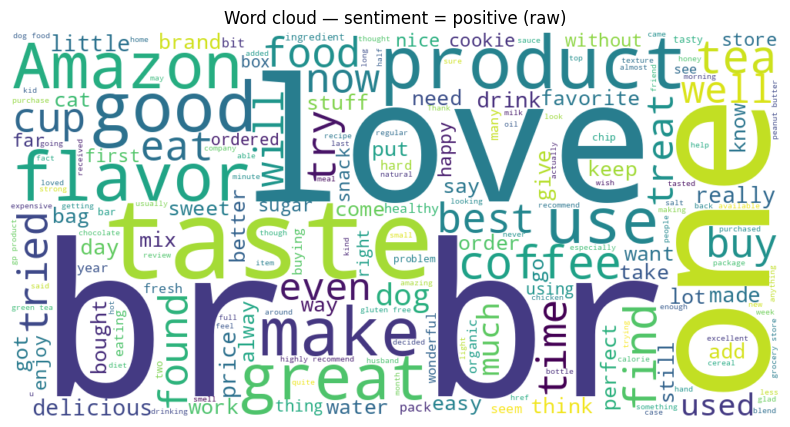

In [348]:
wordcloud_for_value(df, "positive", use_clean=False)

---
---
# Data Prep
---
---

In [352]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,review_time,text_len,word_count,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,263,48,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,190,31,negative


dropping columns that do not affect text modelling

In [353]:
df = df.drop(['Id', 'ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score'], axis=1)

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415390 entries, 0 to 415389
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Summary      415390 non-null  object        
 1   Text         415390 non-null  object        
 2   review_time  415390 non-null  datetime64[ns]
 3   text_len     415390 non-null  int64         
 4   word_count   415390 non-null  int64         
 5   sentiment    415390 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 19.0+ MB


checking for null values

In [355]:
df.isna().sum()

,0
Summary,0
Text,0
review_time,0
text_len,0
word_count,0
sentiment,0


dropping duplicates

In [356]:
df = df.drop_duplicates(subset=["Text"])

In [357]:
df.shape

(287024, 6)

getting stats for helper column

In [358]:
df[["word_count", "text_len"]].describe()

,word_count,text_len
count,287024.000000,287024.000000
mean,74.926400,407.278705
std,72.742104,407.741394
min,3.000000,12.000000
25%,32.000000,174.000000
50%,53.000000,286.000000
75%,91.000000,490.000000
max,2520.000000,16952.000000


Removing rows where word count is less than 20
Removing reviews with fewer than 20 words helps reduce noise and make the model learn from actual sentences instead of tiny, uninformative comments.

under 10

In [359]:
# how many rows would we drop if we put < 10
to_drop = df[df["word_count"] < 10]
print(len(to_drop))

51


In [360]:
# how are these rows distributed across the positive and negative
print(to_drop["sentiment"].value_counts())

sentiment
positive    49
negative     2
Name: count, dtype: int64


under 20

In [361]:
# how many rows would we drop if we put < 10
to_drop_20 = df[df["word_count"] < 20]
print(len(to_drop_20))

9054


In [362]:
# how are these rows distributed across positive and negative
print(to_drop_20["sentiment"].value_counts())

sentiment
positive    8425
negative     629
Name: count, dtype: int64


rows ro drop over 1000 words

In [363]:
# define the threshold
THRESH = 1000

# boolean mask: True for rows you'd drop
to_drop_mask = df["word_count"] >= THRESH

# how many rows is that?
num_to_drop = to_drop_mask.sum()
print("Rows to drop:", num_to_drop)

# optionally, look at them
rows_to_drop = df[to_drop_mask]
rows_to_drop[["Text", "word_count"]].head()


Rows to drop: 88


,Text,word_count
6243,And we find her here upon this grand amazon!<b...,1513
7119,"We breastfeed our month old boy, but since his...",1751
20728,"QUALITY<br />In my opinion, having used a doze...",1377
27915,Dang it! I've been l@@king literally everywher...,1026
28147,the other ingredients are not so healthy and u...,1189


In [364]:
df = df[(df["word_count"] >= 20) & (df["word_count"] <= 1000)]

In [365]:
print(df["sentiment"].value_counts())
print((df["sentiment"].value_counts(normalize=True)*100).round(2))

sentiment
positive    242244
negative     35638
Name: count, dtype: int64
sentiment
positive    87.18
negative    12.82
Name: proportion, dtype: float64


Full text cleaning

In [366]:
# === ONE BIG CLEAN with NEG/NOISE handling ===
import re, html, unicodedata
try:
    from bs4 import BeautifulSoup
    _HAS_BS4 = True
except Exception:
    _HAS_BS4 = False

# keep negations (critical for sentiment)
NEG   = {"not","no","nor","never"}

# tokens to REMOVE if they appear as stand-alone words
# (html/url/site artefacts + any extras you listed)
NOISE = {
    "br","href","http","https","www","com","amazon","gp","product",
    "ve","amp","nbsp","quot","lt","gt"
}

URL_RE        = re.compile(r"(https?://\S+|www\.\S+)", flags=re.I)
HTMLTAG_RE    = re.compile(r"<[^>]+>")
ENT_WORDS_RE  = re.compile(r"\b(?:amp|nbsp|quot|lt|gt)\b", flags=re.I)
NOISE_RE      = re.compile(r"\b(?:" + "|".join(sorted(NOISE)) + r")\b", flags=re.I)
MULTISPACE_RE = re.compile(r"\s+")
EDGE_SPACE_RE = re.compile(r"^\s+|\s+$")

def clean_text_strict(s: str) -> str:
    # to string + unescape (&amp; -> &)
    s = html.unescape(str(s))
    # remove URLs
    s = URL_RE.sub(" ", s)
    # strip HTML tags
    if _HAS_BS4:
        s = BeautifulSoup(s, "lxml").get_text(" ")
    else:
        s = HTMLTAG_RE.sub(" ", s)
    # unicode normalize, lowercase
    s = unicodedata.normalize("NFKC", s).lower()
    # drop common entity words
    s = ENT_WORDS_RE.sub(" ", s)
    # remove explicit NOISE tokens as whole words
    s = NOISE_RE.sub(" ", s)
    # collapse spaces / trim
    s = MULTISPACE_RE.sub(" ", s)
    s = EDGE_SPACE_RE.sub("", s)
    return s

# Apply to Text
df["Text_clean"] = df["Text"].apply(clean_text_strict)
before = len(df)
df = df[df["Text_clean"].str.len() > 0].copy()
print(f"Cleaned text created. Dropped empty rows: {before - len(df)}; kept {len(df)}")


Cleaned text created. Dropped empty rows: 807; kept 277075


In [367]:
df = df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277075 entries, 0 to 277074
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   index        277075 non-null  int64         
 1   Summary      277075 non-null  object        
 2   Text         277075 non-null  object        
 3   review_time  277075 non-null  datetime64[ns]
 4   text_len     277075 non-null  int64         
 5   word_count   277075 non-null  int64         
 6   sentiment    277075 non-null  object        
 7   Text_clean   277075 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 16.9+ MB


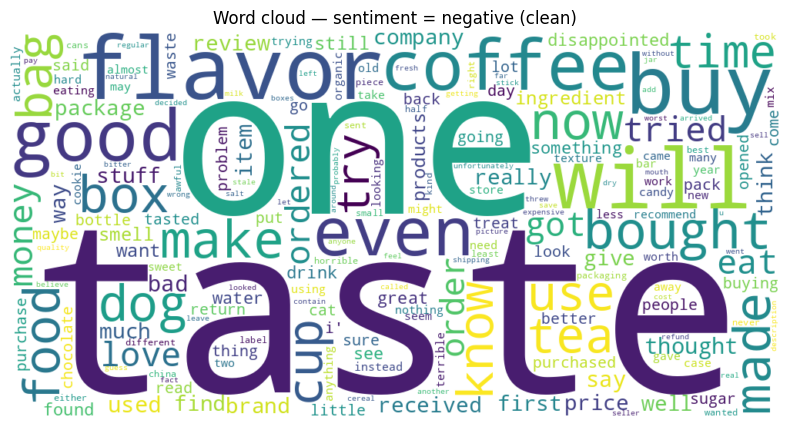

In [368]:

wordcloud_for_value(df, "negative", use_clean=True)


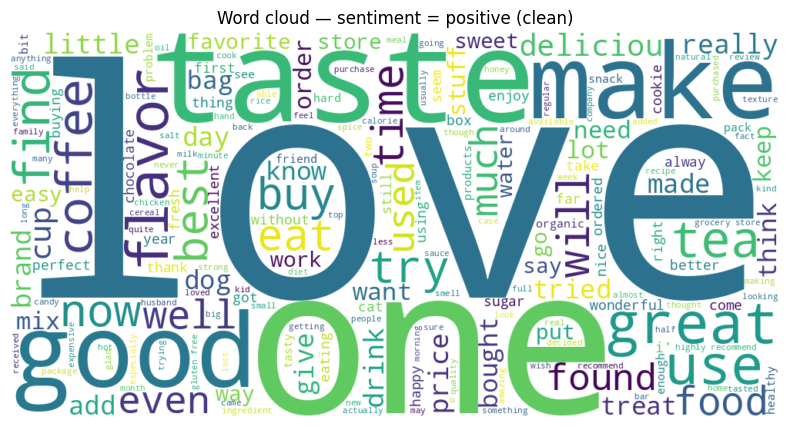

In [369]:
wordcloud_for_value(df, "positive", use_clean=True)

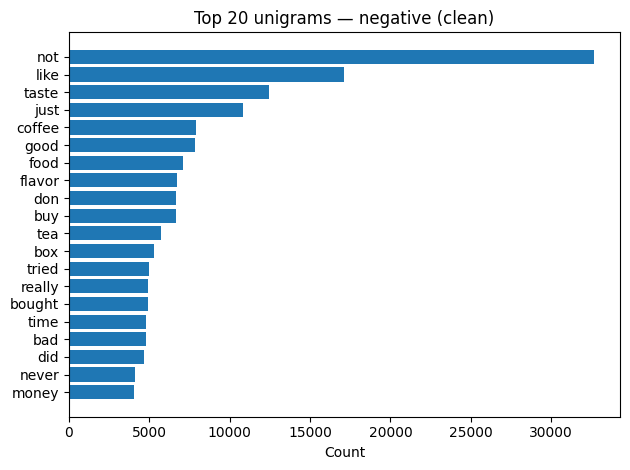

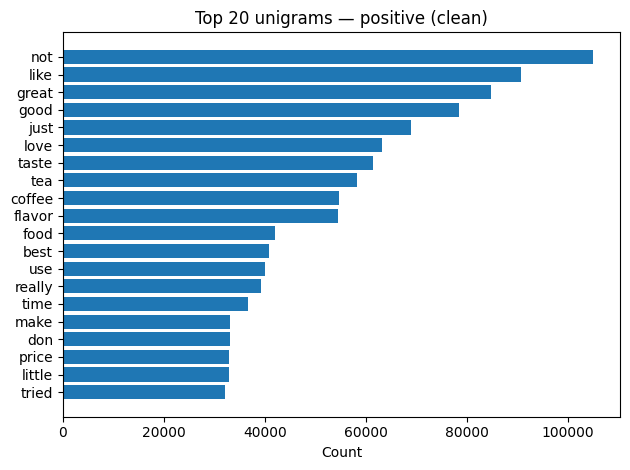

In [381]:
for lbl in ["negative","positive"]:
    top_terms_clean(df, lbl, ngram=(1,1))

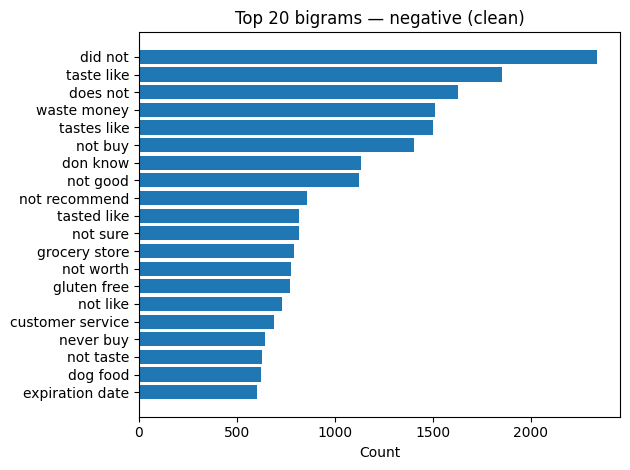

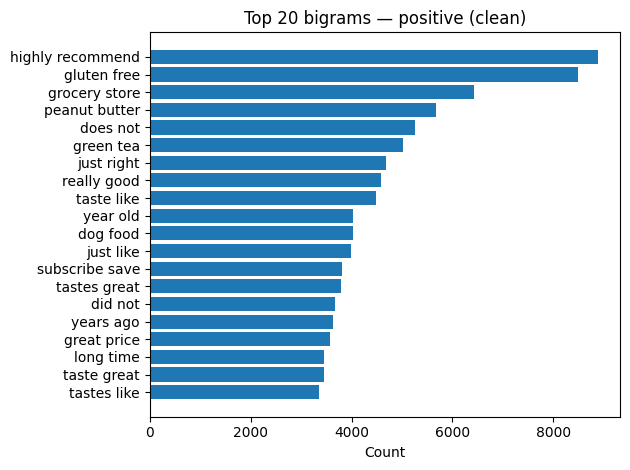

In [382]:
for lbl in ["negative","positive"]:
    top_terms_clean(df, lbl, ngram=(2,2), max_features=40000)

---
---
# Final dataset
---
---

In [372]:
df = df[["Text_clean","sentiment"]]

In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277075 entries, 0 to 277074
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Text_clean  277075 non-null  object
 1   sentiment   277075 non-null  object
dtypes: object(2)
memory usage: 4.2+ MB


# EDA summary

- Checked integrity: nulls, duplicate `Text`, and overall schema.
- Built **helper columns** (EDA-only → later reused): `review_time` (from Unix), `word_count`, `text_len`.
- Explored **label balance** via `Score` (1–5), **time coverage** (1999–2012), and **length distributions** (hist + box by score).
- Visualised vocabulary on **raw text**:
  - Word clouds for **Score 1** and **Score 5**.
  - **Top-20 unigrams & bigrams** per score (1 & 5).
- Decided to focus modelling on **extremes (1★ vs 5★)** to reduce label noise and improve separability.

# Data preparation summary

- Created **`Text_clean`**: stripped HTML tags/entities & URLs, lowercased, collapsed spaces; removed site/HTML noise tokens; **kept negations** (`not/no/nor/never`).
- Recomputed **`word_count`** and **`text_len`** from `Text_clean`.
- Derived binary label **`sentiment`** (negative for 1★, positive for 5★) and filtered out 2–4★.
- Produced vocabulary visuals on **clean text**:
  - **Top-20 unigrams & bigrams** per sentiment (negative/positive).
- Current working frame: **277,882 rows**, columns: `Summary`, `Text`, `review_time`, `text_len`, `word_count`, `sentiment`, `Text_clean`.
  *(You can later drop unused columns before modelling.)*

# Key decisions (justification)

- **1★ & 5★ only:** clearer signal, less label noise from mixed mid-scores.
- **Length rule:** keep **20–1000 words** (guided by length distributions).
- **Cleaning choices:** remove HTML/URLs & boilerplate, **preserve negation** terms critical for sentiment.
- Keep both **raw & clean** views in EDA for transparency.

# Ready for next steps

- Stratified **train/test split** on `sentiment`.
- Baselines: **TF-IDF + Logistic**, **TF-IDF + LinearSVC**.
- Advanced: **TF-IDF → SVD → MLP** comparison (macro-F1, confusion matrices).

#Saving it in a CSV file for modeling

In [374]:
df.to_csv("clean_amazon_reviews.csv", index=False)

In [375]:
# Normal way of improting is breaking a few lines in the file.
# QUOTE_ALL stops those “EOF inside string” errors because every text field is properly wrapped.

from google.colab import drive
drive.mount("/content/drive")

df.to_csv(
    "/content/drive/MyDrive/clean_amazon_reviews.csv",
    index=False,
    encoding="utf-8",
    quoting=csv.QUOTE_ALL,   # quote everything so text doesn't break
    lineterminator="\n"
)


Mounted at /content/drive


In [376]:
from google.colab import files
files.download("clean_amazon_reviews.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
---
---
# Functions
---
---
---

Word Cloud

In [377]:
# ==== column aliases ====
SENTIMENT_COL = "sentiment"
TEXT_COL_RAW  = "Text"
TEXT_COL_CLEAN = "Text_clean"   # create this earlier with your cleaner


def wordcloud_for_value(df, value, *, use_clean=True, by=SENTIMENT_COL,
                        max_reviews=50_000, title=None):
    """
    Make a word cloud for rows where `df[by] == value`.
    - by: column to filter on (default = SENTIMENT_COL)
    - value: value to match (e.g., "negative" or 5)
    - use_clean: if True, prefer TEXT_COL_CLEAN; else use TEXT_COL_RAW
    """
    text_col = (TEXT_COL_CLEAN if use_clean and TEXT_COL_CLEAN in df.columns
                else TEXT_COL_RAW)

    subset = df.loc[df[by] == value, text_col].astype(str)
    if subset.empty:
        print(f"No rows where {by} == {value}")
        return

    if len(subset) > max_reviews:
        subset = subset.sample(max_reviews, random_state=42)

    wc = WordCloud(width=1000, height=500, background_color="white").generate(" ".join(subset))

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title or f"Word cloud — {by} = {value} ({'clean' if use_clean else 'raw'})")
    plt.show()


### Raw
* Unigram and Bigram

In [378]:
def top_terms_raw_score(df, score, ngram=(1,1), topn=20, min_df=3, max_features=20000):
    """
    Plot Top-N terms from RAW Text for rows with Score == score.
    ngram=(1,1) -> unigrams; ngram=(2,2) -> bigrams.
    """
    texts = df.loc[df["Score"] == score, "Text"].astype(str)
    if texts.empty:
        print(f"No rows with Score == {score}")
        return

    vec = CountVectorizer(
        stop_words=list(ENGLISH_STOP_WORDS),
        ngram_range=ngram,
        min_df=min_df,
        max_features=max_features
        # NOTE: no token_pattern override -> use sklearn default for raw text
    )
    X = vec.fit_transform(texts)
    vocab = vec.get_feature_names_out()
    freqs = X.sum(axis=0).A1
    order = np.argsort(freqs)[-topn:][::-1]

    plt.barh(range(len(order)), freqs[order][::-1])
    plt.yticks(range(len(order)), vocab[order][::-1])
    plt.xlabel("Count")
    plt.title(f"Top {topn} {'uni' if ngram==(1,1) else 'bi'}grams — Score {score} (raw)")
    plt.tight_layout()
    plt.show()


### Clean
* Unigram and Bigram

In [380]:
def top_terms_clean(df, sentiment, ngram=(1,1), topn=20, min_df=3, max_features=20000):
    texts = df.loc[df["sentiment"] == sentiment, "Text_clean"].astype(str)
    vec = CountVectorizer(stop_words=list(STOP),
                          ngram_range=ngram, min_df=min_df, max_features=max_features,
                          token_pattern=r"(?u)\b[a-z]{3,}\b")
    X = vec.fit_transform(texts)
    vocab = vec.get_feature_names_out()
    freqs = X.sum(axis=0).A1
    order = np.argsort(freqs)[-topn:][::-1]
    plt.barh(range(len(order)), freqs[order][::-1])
    plt.yticks(range(len(order)), vocab[order][::-1])
    plt.xlabel("Count")
    plt.title(f"Top {topn} {'uni' if ngram==(1,1) else 'bi'}grams — {sentiment} (clean)")
    plt.tight_layout(); plt.show()
